# LJ GEMC

In [1]:
import sys, os
import glob
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from simtk import unit

from scipy import interpolate

from thermoextrap.gpr_active import active_utils
from run_active_LJ_GEMC import (
    transform_lognorm,
    make_ground_truth_dens,
    DataWrapDensities,
)

2022-11-17 22:13:44.780860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preliminaries

In [2]:
# Define base directory to work with
base_dir = os.path.expanduser("~/GPR_Extrapolation/LJ_EOS/GEMC")

In [3]:
# Create ground truth for comparison
ground_truth_dens = make_ground_truth_dens()

In [4]:
# If do need GP model, need to load data
# Make easy to do that
def load_data(dir_name, beta_list):
    data_list = []

    for i, beta in enumerate(beta_list):
        d = "%s/beta_%f" % (dir_name, beta)
        data_list.append(
            DataWrapDensities(
                sorted(glob.glob("%s/sim_info_out*.txt" % d)),
                sorted(glob.glob("%s/cv_bias_out*.txt" % d)),
                beta,
                x_files=sorted(glob.glob("%s/dens_out*.txt" % d)),
                u_col=-1,
                x_col=[1, 2],
                n_frames=2000,
            )
        )

    return data_list

## Density

In [5]:
# Find all runs
run_dirs = sorted(glob.glob("%s/run*" % base_dir))

# Load all training information
train_info = [np.load("%s/active_history.npz" % (rdir)) for rdir in run_dirs]

# Define beta values for model evaluation (expected to match stop train_info)
b_vals = np.linspace(1 / 1.2, 1 / 0.7, 1000)

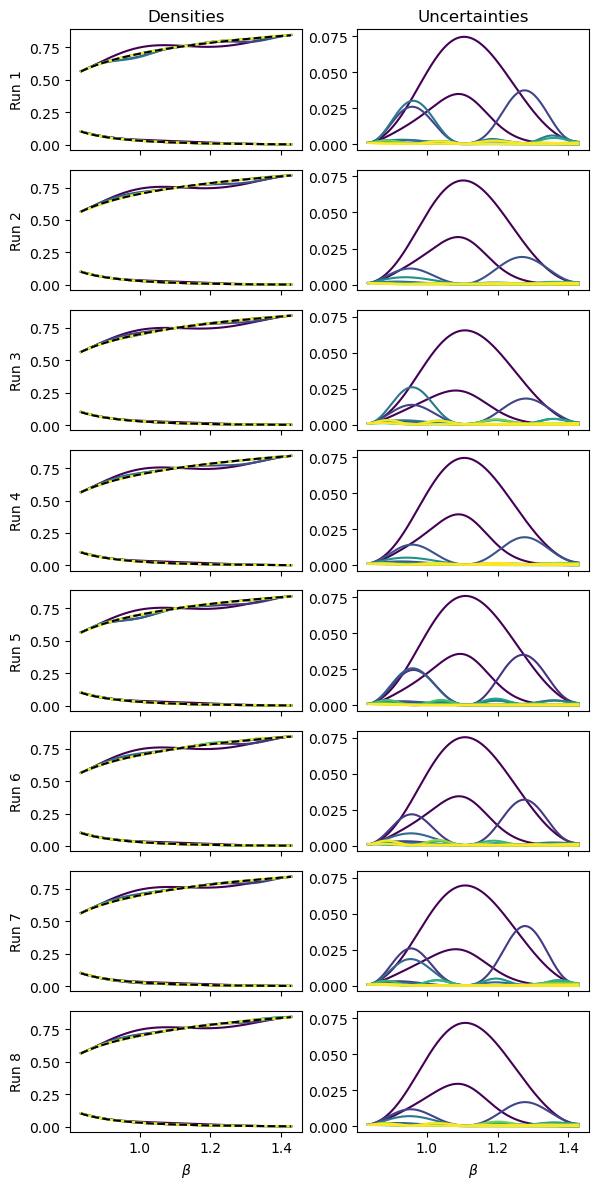

In [6]:
# Plot results over all runs
fig, ax = plt.subplots(
    len(train_info), 2, sharex=True, sharey="col", figsize=(6, 1.5 * len(train_info))
)

for i, info in enumerate(train_info):
    this_mean = info["pred_mu"]
    this_std = info["pred_std"]
    iter_colors = plt.cm.viridis(np.linspace(0.0, 1.0, this_mean.shape[0]))
    for j in range(this_mean.shape[0]):
        ax[i, 0].plot(b_vals, this_mean[j, :], color=iter_colors[j])
        ax[i, 1].plot(b_vals, this_std[j, :], color=iter_colors[j])
    ax[i, 0].plot(b_vals, ground_truth_dens(b_vals), "k--")
    ax[i, 0].set_ylabel("Run %i" % (i + 1))

ax[-1, 0].set_xlabel(r"$\beta$")
ax[-1, 1].set_xlabel(r"$\beta$")
ax[0, 0].set_title("Densities")
ax[0, 1].set_title("Uncertainties")

fig.tight_layout()
plt.show()

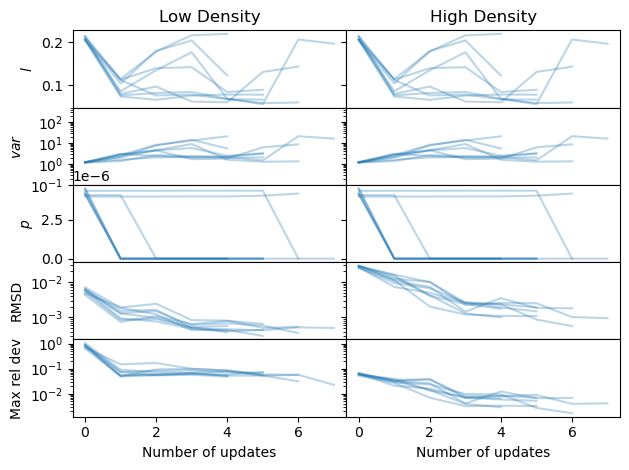

In [7]:
# Examine convergence based on GP parameters and distance from ground truth
fig, ax = plt.subplots(3 + 2, 2, sharex=True, sharey="row")

for i, t_info in enumerate(train_info):
    for k in range(3):
        ax[k, 0].plot(t_info["params"][:, k], color="tab:blue", alpha=0.3)
        ax[k, 1].plot(t_info["params"][:, k], color="tab:blue", alpha=0.3)

    this_gt = ground_truth_dens(b_vals)
    for k in range(2):
        this_rmsd = np.sqrt(
            np.average((t_info["pred_mu"][..., k] - this_gt[:, k]) ** 2, axis=-1)
        )
        this_max_rel_dev = np.max(
            abs(t_info["pred_mu"][..., k] - this_gt[:, k]) / abs(this_gt[:, k]), axis=-1
        )
        ax[3, k].plot(this_rmsd, color="tab:blue", alpha=0.3)
        ax[3 + 1, k].plot(this_max_rel_dev, color="tab:blue", alpha=0.3)

for i in range(2):
    ax[-1, i].set_xlabel(r"Number of updates")

ax[1, 0].set_yscale("log")
ax[1, 0].set_ylim((1e-1, 500.0))
ax[-1, 0].set_yscale("log")
ax[-2, 0].set_yscale("log")

ax[0, 0].set_ylabel(r"$l$")
ax[1, 0].set_ylabel(r"$var$")
ax[2, 0].set_ylabel(r"$p$")
ax[3, 0].set_ylabel(r"RMSD")
ax[4, 0].set_ylabel(r"Max rel dev")

ax[0, 0].set_title("Low Density")
ax[0, 1].set_title("High Density")

fig.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

plt.show()

In [8]:
# To really convince, show single run snapshots with 2 end points, 1 update, then the final model
# Or show all runs in single figure in SI
# For sure in main text, want figure showing relative deviation from ground truth next to predicted relative uncertainty
# (for both densities)
# Idea is to show that (1) models get very good and (2) models accurately predict confidence
# So really want to show deviations from ground truth and confidence intervals versus number of updates
# Can do on single figure with zero being no deviation, then show points for deviations and lines for confidence intervals
# Want to see that mainly points are inside lines

In [9]:
# For each run, will show progression of model with appropriate confidence intervals drawn
# So need to load and train each model each time
# Will store model output (means, std, confidence intervals) for plotting later
all_betas = {}
all_means = {}
all_stds = {}
all_conf_ints = {}

# Will need base update function to be able to get GP output easily
update_func = active_utils.UpdateFuncBase(transform_func=transform_lognorm)

for i, t_info in enumerate(train_info):
    this_betas = []
    this_means = []
    this_stds = []
    this_conf_ints = []
    for k, ind in enumerate([0, 1, -1]):
        if ind >= 0:
            ind += 2
        else:
            k = ind
        this_alphas = t_info["alpha"][:ind]
        this_data_list = load_data("%s" % run_dirs[i], this_alphas)
        this_states = [dat.build_state(max_order=4) for dat in this_data_list]
        this_gp = active_utils.create_GPR(this_states, start_params=t_info["params"][k])
        alpha_grid, alpha_select = update_func.create_alpha_grid(this_alphas)
        gpr_mean, gpr_std, gpr_conf_ints = update_func.get_transformed_GP_output(
            this_gp, alpha_select
        )
        this_betas.append(alpha_select)
        this_means.append(gpr_mean)
        this_stds.append(gpr_std)
        this_conf_ints.append(gpr_conf_ints)
    all_betas["run%i" % i] = np.array(this_betas)
    all_means["run%i" % i] = np.array(this_means)
    all_stds["run%i" % i] = np.array(this_stds)
    all_conf_ints["run%i" % i] = np.array(this_conf_ints)

/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
2022-11-17 22:14:40.113383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical 

In [10]:
def plot_GP_predictions(x, y, err, alpha_list, ax):
    compare_y = ground_truth_dens(x[:, None])
    # Need loop to handle multiple outputs if have them
    for k in range(y.shape[1]):
        ax.plot(x, y[:, k])
        ax.fill_between(x, err[0][:, k], err[1][:, k], alpha=0.2)
        ax.plot(x, compare_y[:, k], "k--")
    # Use compare_func output to set range of plot
    compare_min = np.min(compare_y)
    compare_max = np.max(compare_y)
    compare_range = compare_max - compare_min
    ax.set_ylim(
        (compare_min - 0.05 * compare_range, compare_max + 0.05 * compare_range)
    )
    # Plot points where collected data for GPR
    y_lims = ax.get_ylim()
    y_range = y_lims[1] - y_lims[0]
    ax.set_ylim((y_lims[0] - 0.10 * y_range, y_lims[1]))
    ax.plot(
        alpha_list,
        (y_lims[0] - 0.05 * y_range) * np.ones_like(alpha_list),
        marker="^",
        color="k",
        linestyle="",
        ms=2.0,
    )

[0.82306132 0.06224315]
[0.07387347 0.03062065]
[0.08221881 0.00694762]
[1.06964963 0.07086571]
[0.05278886 0.02791076]
[0.05754857 0.00699919]
[0.61232633 0.06682538]
[0.05512394 0.02583139]
[0.08652543 0.00338333]
[0.89857594 0.06099476]
[0.06021595 0.04015162]
[0.06136921 0.00320707]
[0.41532182 0.08861809]
[0.09855642 0.04339813]
[0.03129735 0.00233243]
[0.89354586 0.05984899]
[0.06566059 0.02738948]
[0.05830356 0.00609247]
[0.86360733 0.06763545]
[0.1240497  0.02674153]
[0.06892632 0.00287337]
[0.68239694 0.06325231]
[0.05830888 0.02638526]
[0.05699854 0.00475519]


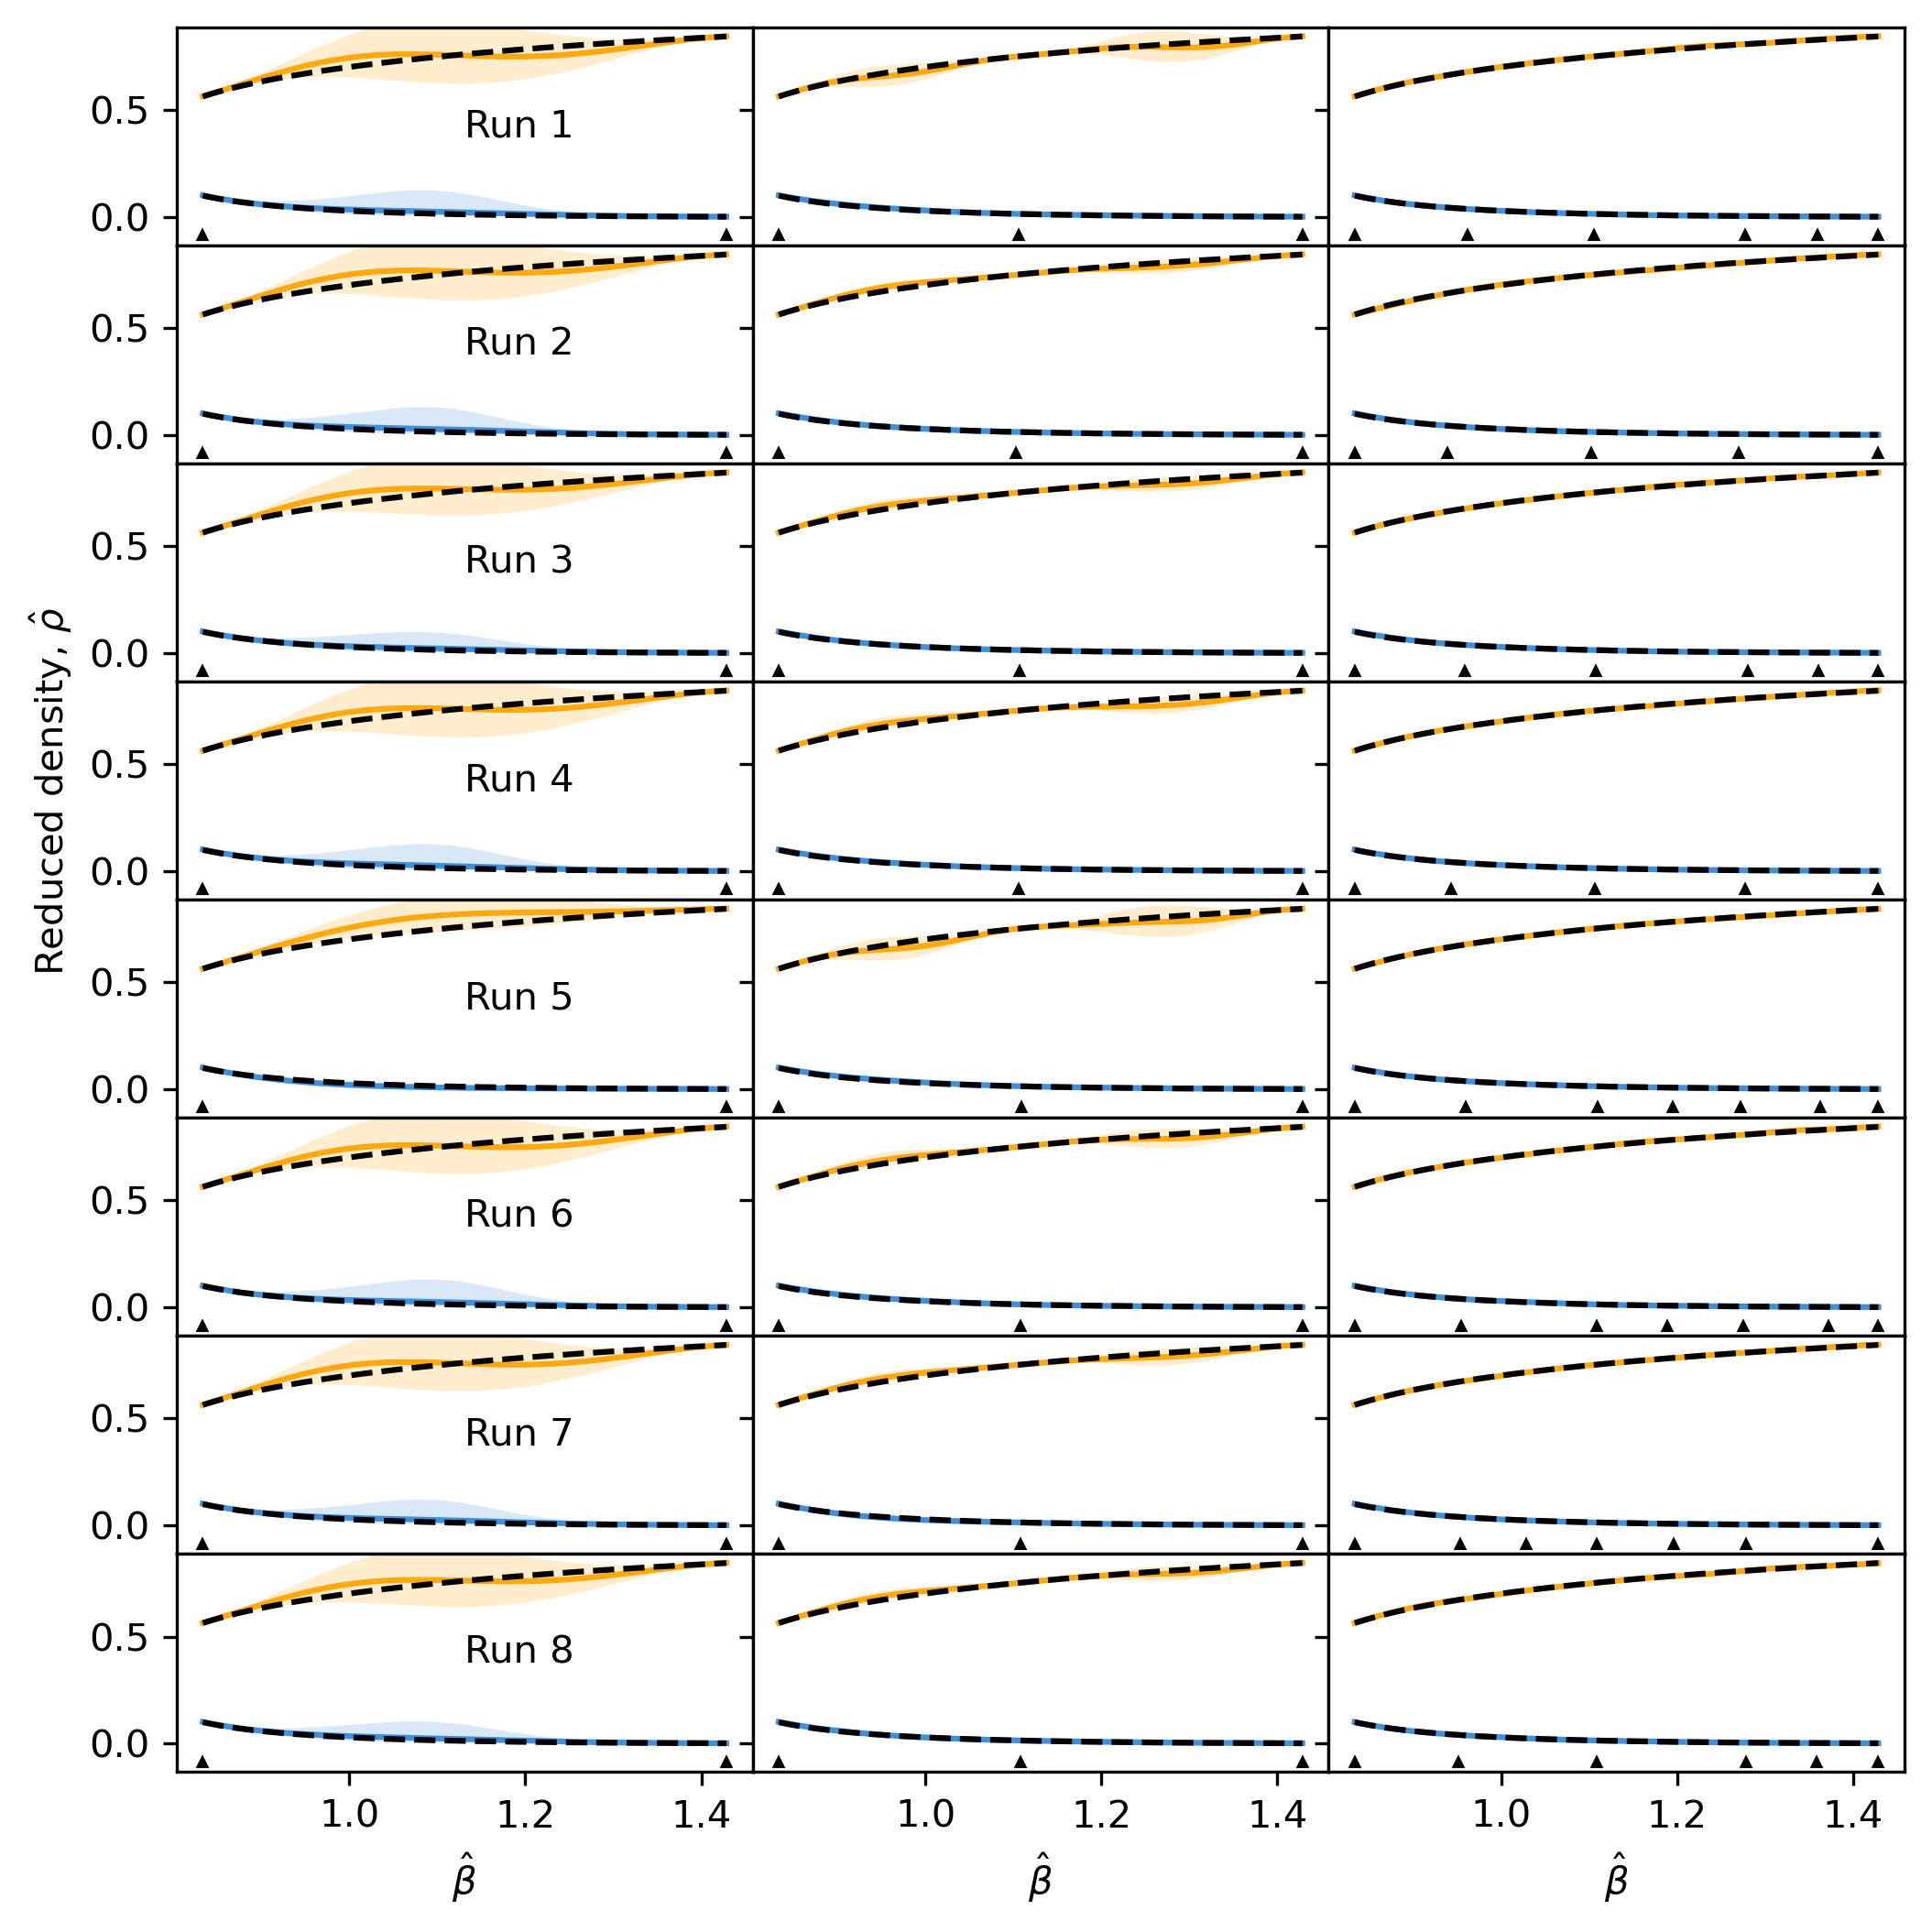

In [11]:
fig, ax = plt.subplots(
    len(train_info), 3, sharex=True, sharey=True, figsize=(7.13, 7.13), dpi=300
)

for i in range(len(train_info)):
    for j, ind in enumerate([0, 1, -1]):
        if ind >= 0:
            ind += 2
        plot_GP_predictions(
            all_betas["run%i" % i][j, :],
            all_means["run%i" % i][j, ...],
            all_conf_ints["run%i" % i][j, ...],
            train_info[i]["alpha"][:ind],
            ax[i, j],
        )
        this_rel_dev = abs(
            all_means["run%i" % i][j, ...]
            - ground_truth_dens(all_betas["run%i" % i][j, :][:, None])
        )
        this_rel_dev /= abs(ground_truth_dens(all_betas["run%i" % i][j, :][:, None]))
        print(np.max(this_rel_dev, axis=0))
    ax[i, 0].annotate("Run %i" % (i + 1), xy=(0.5, 0.5), xycoords="axes fraction")

for i in range(3):
    ax[-1, i].set_xlabel(r"$\hat{\beta}$")

ax[3, 0].set_ylabel(r"Reduced density, $\hat{\rho}$")

fig.tight_layout()
fig.subplots_adjust(wspace=0.0, hspace=0.0)

plt.show()

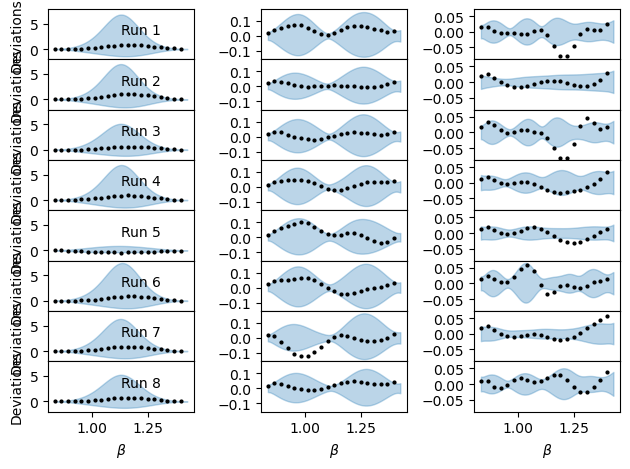

In [12]:
# Examine deviations for low densities
dens_ind = 0

fig, ax = plt.subplots(len(train_info), 3, sharex=True, sharey="col")

for i in range(len(train_info)):
    for j in range(3):
        this_betas = all_betas["run%i" % i][j, :]
        this_means = all_means["run%i" % i][j, :, dens_ind]
        this_gt = ground_truth_dens(this_betas)[:, dens_ind]
        this_dev = (this_means - this_gt) / np.abs(this_gt)
        ax[i, j].plot(this_betas[::50], this_dev[::50], "ko", ms=2)
        ax[i, j].fill_between(
            this_betas,
            (all_conf_ints["run%i" % i][j, 0, :, dens_ind] - this_means)
            / np.abs(this_gt),
            (all_conf_ints["run%i" % i][j, 1, :, dens_ind] - this_means)
            / np.abs(this_gt),
            color="tab:blue",
            alpha=0.3,
        )
    ax[i, 0].set_ylabel(r"Deviations")
    ax[i, 0].annotate("Run %i" % (i + 1), xy=(0.5, 0.5), xycoords="axes fraction")

for i in range(3):
    ax[-1, i].set_xlabel(r"$\beta$")

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

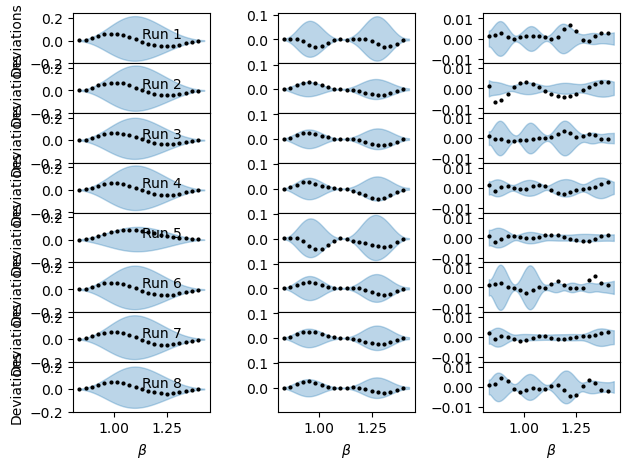

In [13]:
# Examine deviations for low densities
dens_ind = 1

fig, ax = plt.subplots(len(train_info), 3, sharex=True, sharey="col")

for i in range(len(train_info)):
    for j in range(3):
        this_betas = all_betas["run%i" % i][j, :]
        this_means = all_means["run%i" % i][j, :, dens_ind]
        this_gt = ground_truth_dens(this_betas)[:, dens_ind]
        this_dev = (this_means - this_gt) / np.abs(this_gt)
        ax[i, j].plot(this_betas[::50], this_dev[::50], "ko", ms=2)
        ax[i, j].fill_between(
            this_betas,
            (all_conf_ints["run%i" % i][j, 0, :, dens_ind] - this_means)
            / np.abs(this_gt),
            (all_conf_ints["run%i" % i][j, 1, :, dens_ind] - this_means)
            / np.abs(this_gt),
            color="tab:blue",
            alpha=0.3,
        )
    ax[i, 0].set_ylabel(r"Deviations")
    ax[i, 0].annotate("Run %i" % (i + 1), xy=(0.5, 0.5), xycoords="axes fraction")

for i in range(3):
    ax[-1, i].set_xlabel(r"$\beta$")

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

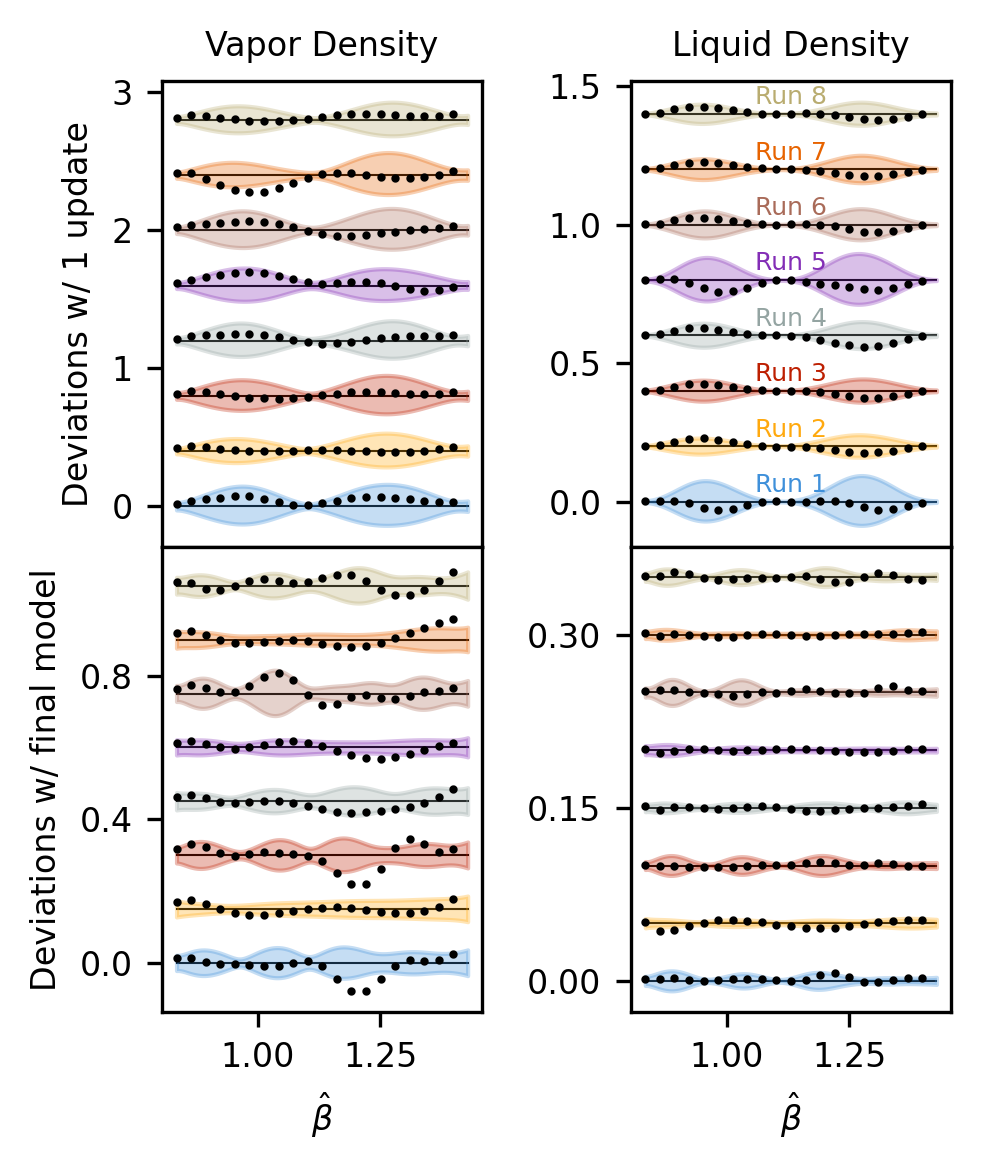

In [15]:
# Summarize above with nicer figure
# Will do 2x2 not share y
# Top row is with 1 update
# Bottom row is all updates
# First column is low density
# Second column is high density
# In each panel, runs are colored differently for confidence intervals, shifted along axis by some amount
# Label runs on plot
fig, ax = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(3.37, 4.0), dpi=300)

shifts = np.array([[0.4, 0.2], [0.15, 0.05]])

# shifts = np.array([[0.015, 0.15],
#                    [0.008, 0.030]])

iter_colors = plt.rcParams["axes.prop_cycle"].by_key()[
    "color"
]  # plt.cm.tab10(np.linspace(0.0, 1.0, this_mean.shape[0]))

for i in range(2):
    for j in range(2):
        for k in range(len(train_info)):
            this_shift = k * shifts[i, j]
            this_betas = all_betas["run%i" % k][i + 1, :]
            this_means = all_means["run%i" % k][i + 1, :, j]
            this_gt = ground_truth_dens(this_betas)[:, j]
            this_dev = (this_means - this_gt) / np.abs(this_gt)
            ax[i, j].plot(this_betas[::50], this_shift + this_dev[::50], "ko", ms=1.0)
            ax[i, j].fill_between(
                this_betas,
                this_shift
                + (all_conf_ints["run%i" % k][i + 1, 0, :, j] - this_means)
                / np.abs(this_gt),
                this_shift
                + (all_conf_ints["run%i" % k][i + 1, 1, :, j] - this_means)
                / np.abs(this_gt),
                alpha=0.3,
                color=iter_colors[k],
            )
            ax[i, j].plot(
                this_betas[[0, -1]],
                this_shift * np.ones(2),
                "k",
                linewidth=0.5,
                zorder=0,
            )
            if i == 0 and j == 1:
                ax[i, j].annotate(
                    "Run %i" % (k + 1),
                    xy=(np.average(this_betas), this_shift + 0.3 * shifts[i, j]),
                    va="center",
                    ha="center",
                    color=iter_colors[k],
                    fontsize=6,
                )
            ax[i, j].yaxis.set_major_locator(MaxNLocator(prune="both", nbins=4))
            ax[i, j].tick_params(axis="both", labelsize=8)

ax[0, 0].set_title("Vapor Density", fontsize=8)
ax[0, 1].set_title("Liquid Density", fontsize=8)
ax[-1, 0].set_xlabel(r"$\hat{\beta}$", fontsize=8)
ax[-1, 1].set_xlabel(r"$\hat{\beta}$", fontsize=8)
ax[0, 0].set_ylabel(r"Deviations w/ 1 update", fontsize=8)
ax[1, 0].set_ylabel(r"Deviations w/ final model", fontsize=8)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

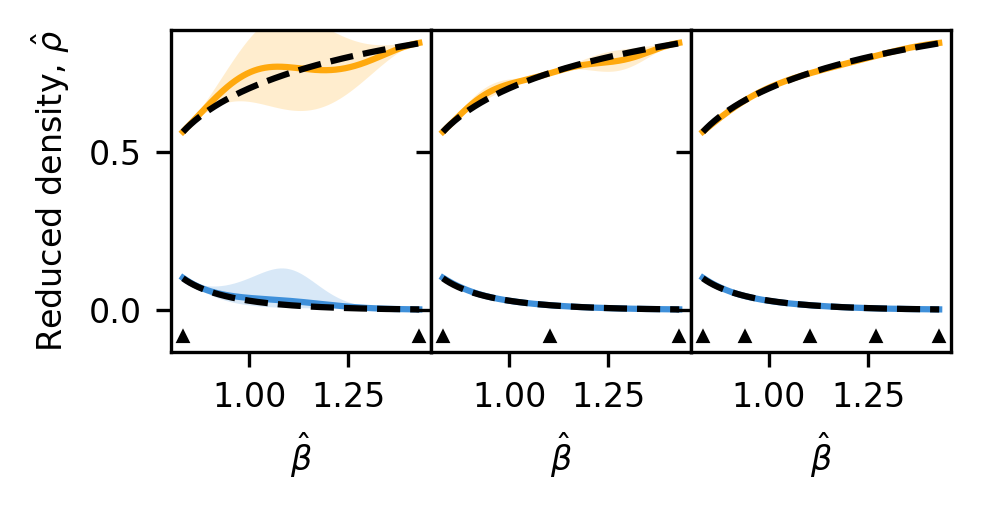

In [17]:
# For single run as example, show updates
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(3.37, 1.8), dpi=300)

run_num = 1
run = "run%i" % run_num  # Took an intermediate number of updates to converge

for j, ind in enumerate([0, 1, -1]):
    if ind >= 0:
        ind += 2
    plot_GP_predictions(
        all_betas[run][j, :],
        all_means[run][j, ...],
        all_conf_ints[run][j, ...],
        train_info[run_num]["alpha"][:ind],
        ax[j],
    )

ax[0].set_ylabel(r"Reduced density, $\hat{\rho}$", fontsize=8)

for i in range(3):
    ax[i].set_xlabel(r"$\hat{\beta}$", fontsize=8)
    ax[i].xaxis.set_major_locator(MaxNLocator(prune="both", nbins=3))
    ax[i].tick_params(axis="both", labelsize=8)

fig.tight_layout()
fig.subplots_adjust(wspace=0.0, hspace=0.0)

plt.show()